# Emotion Identification from Facial Expression - Convolutional Neural Network (CNN) Project
In the following multi-class classification project, CNN technique has been employed to recognize emotion from facial expression within a dataset of 15,000 images. This projects includes the following sections:

* Loading the dataset
* Building the model
* Defining loss function and optimizer
* Trainig the model and evaluation
* Testing the model

# 1 Import Packages

First, we need to import packages that will be used later.

In [ ]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# tqdm is used for the progress bar.
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 Download the Facial Expression Recognition Dataset

The dataset used here is Real-world Affective Faces Database [RAF-DB](https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/) on Kaggle
, a collection of facial expression images in 7 classes ('suprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral').

Original paper published with RAF-DB: [Reliable Crowdsourcing and Deep Locality-Preserving Learning for Expression
 Recognition in the Wild, CVPR 2017](https://openaccess.thecvf.com/content_cvpr_2017/papers/Li_Reliable_Crowdsourcing_and_CVPR_2017_paper.pdf).

In [ ]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [ ]:
# opendatasets is a Python library that provides utilities for downloading datasets from various online sources
import opendatasets as od
import pandas as pd

In [ ]:
# insert your kaggle username and key
od.download('https://www.kaggle.com/datasets/shuvoalok/raf-db-dataset/')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aminmehranfar
Your Kaggle Key: ··········


100%|██████████| 37.7M/37.7M [00:00<00:00, 129MB/s] 


## 2.2 PyTorch Dataset and Dataloader

Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply **torchvision.datasets.ImageFolder** for wrapping data without much effort.

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.

In [ ]:
train_transform = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 224)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# All we need here is to resize the PIL (Python Imaging Library) image and transform it into Tensor.
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = datasets.ImageFolder("raf-db-dataset/DATASET/train", transform=train_transform)
test_dataset = datasets.ImageFolder("raf-db-dataset/DATASET/test", transform=test_transform)

In [ ]:
# Define the desired ratio for train and evaluation data (e.g., 90% train, 10% evaluation)
train_ratio = 0.9
val_ratio = 1 - train_ratio

# Calculate the sizes of train and evaluation datasets based on the ratios
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the train dataset into train and evaluation subsets
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

print(f'Original train set has {len(train_dataset)} samples')
print(f'Train set has {len(train_subset)} samples')
print(f'Validation set has {len(val_subset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Original train set has 12271 samples
Train set has 11043 samples
Validation set has 1228 samples
Test set has 3068 samples


In [ ]:
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True) # creates a DataLoader object for iterating over the training subset
valid_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True) # Shuffling the data during validation is not strictly necessary
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

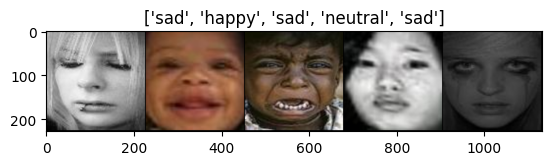

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # convert tensor to np array, then transposing it
    plt.imshow(inp)                        # plt shows the image represented by the NumPy array
    if title is not None:
        plt.title(title)
    plt.pause(0.001)    # pause a bit so that plots are updated. This can be useful when displaying multiple images sequentially.

# Get a batch of training data
train_loader_for_vis = DataLoader(train_subset, batch_size=5, shuffle=True, num_workers=0) # creates a DataLoader object
inputs, classes = next(iter(train_loader_for_vis)) # it retrieves a batch of data from the train_loader_for_vis

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
class_names = ['suprised', 'fearful', 'disgusted', 'happy', 'sad', 'angry', 'neutral']
imshow(out, title=[class_names[x] for x in classes])

# 3 Model

The basic model here is simply a stack of **convolutional layers** followed by some **fully-connected layers**.

Since there are three channels for a color image (RGB), the **input channels** of the network must be **three**.
In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the **feature map must be flattened into a single one-dimensional vector** (for each image).
These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.



**torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)**

For details, please visit [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html).


**torch.nn.MaxPool2d(kernel_size, stride=None, padding=0)**

For details, please visit [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html).


In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # input image size: [3, 224, 224]     default format of tensors in pytorch: [channel, height, width]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),        # output: [64,224,224]
            nn.ReLU(),                        # activation function.
            nn.MaxPool2d(2, 2, 0),            # output: [64,112,112]

            nn.Conv2d(64, 128, 3, 1, 1),      # [128,112,112]
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),            # [128,56,56]

            nn.Conv2d(128, 256, 3, 1, 1),     # [256,56,56]
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0),            # [256,14,14] this is the output dimension of CNNs
        )

        # designing 3 fully connected (FC) layers
        # the input of the 1st FC layer is the flattened output of previous CNN layers. the flattened size is: 256*14*14
        # in FC layers below, 256 is hidden size.
        # the output of FC layes is equal to number of classes (7)
        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 7)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
model = MyCNN()
model = model.to(device)

# 4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer. It updates weights and biases to minimize loss.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003) # Adam is a popular optimization algorithm used for training neural networks.

# 5 Train and Validation

The basic structure of training a deep learning model with multiple epochs and batches. Here's how the loop generally works:

**1. Outer Loop (Epochs):**

The outer loop iterates over a fixed number of epochs (e.g., 100 epochs).
Each epoch represents one complete pass through the entire training dataset.
During each epoch, the model is trained on the entire dataset in multiple batches.

**2. Inner Loop (Batches):**

Inside each epoch, there is an inner loop that iterates over all the batches in the dataset.

For example, if you have 50 batches, this inner loop would iterate 50 times.
Each iteration of this inner loop processes one batch of data.

**3. Training Procedure:**

Inside the inner loop, the following steps typically occur:

**Forward Pass:** The model predicts outputs for the current batch of input data.

**Loss Computation:** The loss function calculates the loss between the predicted outputs and the true labels.

**Backward Pass (Gradient Calculation):** Gradients of the loss with respect to the model parameters (weights and biases) are computed using backpropagation.

**Parameter Update (Optimization):** The optimizer updates the model parameters using the computed gradients to minimize the loss.

**4. Epoch-level Reporting:**

After each epoch (outer loop iteration), you may report metrics such as the average loss across all batches in that epoch.

This allows you to monitor the progress of training and make decisions such as adjusting learning rates or early stopping based on the observed performance.

**5. Goal:**

The goal of training over multiple epochs is to iteratively reduce the training loss and improve the model's performance on the training dataset.
By repeatedly exposing the model to the entire dataset and updating its parameters based on the observed errors (loss), the model learns to make better predictions over time.

In [ ]:
# The number of training epochs.
n_epochs = 100

# These are used to record information
best_valid_acc = 0
patience = 3
counter = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch # batch unpacking
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs) # logits are predicted probabilities (7 probabilities for 7 classes)

        # Calculate the cross-entropy loss.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters (weights and biases) with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

    if valid_acc_epochs[-1] <= best_valid_acc:
        counter = counter + 1
        print(f'EarlyStopping counter: {counter} out of {patience}') # define early stopping
        if counter >= patience:
            print("Early stopping")
            break
    else:
        best_valid_acc = valid_acc_epochs[-1]
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')

  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 001/100] Train: loss=1.39213, acc=0.48997 | Valid: loss=1.10429, acc=0.58387


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 002/100] Train: loss=1.02911, acc=0.63171 | Valid: loss=0.97698, acc=0.63381


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 003/100] Train: loss=0.85265, acc=0.69611 | Valid: loss=0.86807, acc=0.68296


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 004/100] Train: loss=0.71994, acc=0.74476 | Valid: loss=0.84402, acc=0.69765


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 005/100] Train: loss=0.58490, acc=0.79085 | Valid: loss=0.84371, acc=0.70994


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 006/100] Train: loss=0.48132, acc=0.82825 | Valid: loss=0.78573, acc=0.73397


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 007/100] Train: loss=0.35964, acc=0.87283 | Valid: loss=0.98210, acc=0.69551
EarlyStopping counter: 1 out of 3


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 008/100] Train: loss=0.26348, acc=0.90968 | Valid: loss=0.90192, acc=0.74012


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 009/100] Train: loss=0.17195, acc=0.94409 | Valid: loss=1.19918, acc=0.71448
EarlyStopping counter: 1 out of 3


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 010/100] Train: loss=0.11884, acc=0.95930 | Valid: loss=1.27893, acc=0.73371
EarlyStopping counter: 2 out of 3


  0%|          | 0/346 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

[Epoch: 011/100] Train: loss=0.08579, acc=0.97010 | Valid: loss=1.54602, acc=0.72917
EarlyStopping counter: 3 out of 3
Early stopping


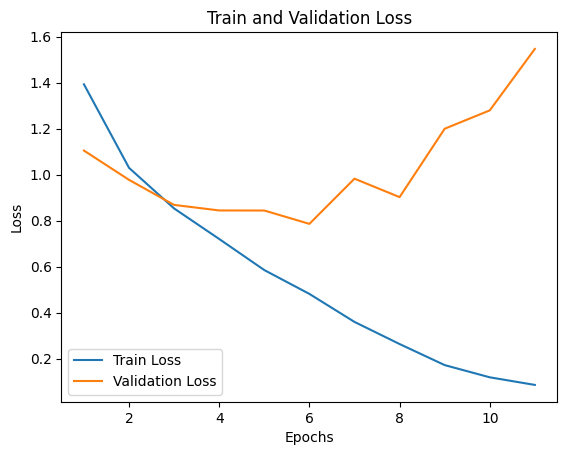

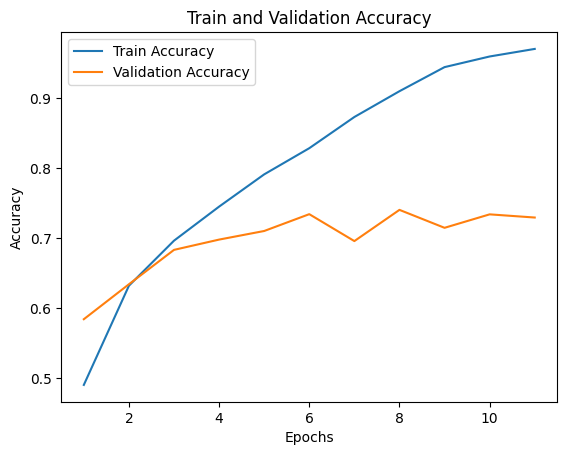

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(range(1, epoch+2), train_loss_epochs, label='Train Loss') # the x-axis represents the epochs or iterations during training
plt.plot(range(1, epoch+2), valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(range(1, epoch+2), train_acc_epochs, label='Train Accuracy')
plt.plot(range(1, epoch+2), valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

# 6 Testing




In [ ]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
# load best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
model.eval()

test_accs = []

# Iterate the testing set by batches. For testing we iterate only on batches, not epochs.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch # batch unpacking
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')

  0%|          | 0/96 [00:00<?, ?it/s]

Test accuracy 0.7540923357009888


# 7 Improve Performance

## 7.1 Data Augmentation

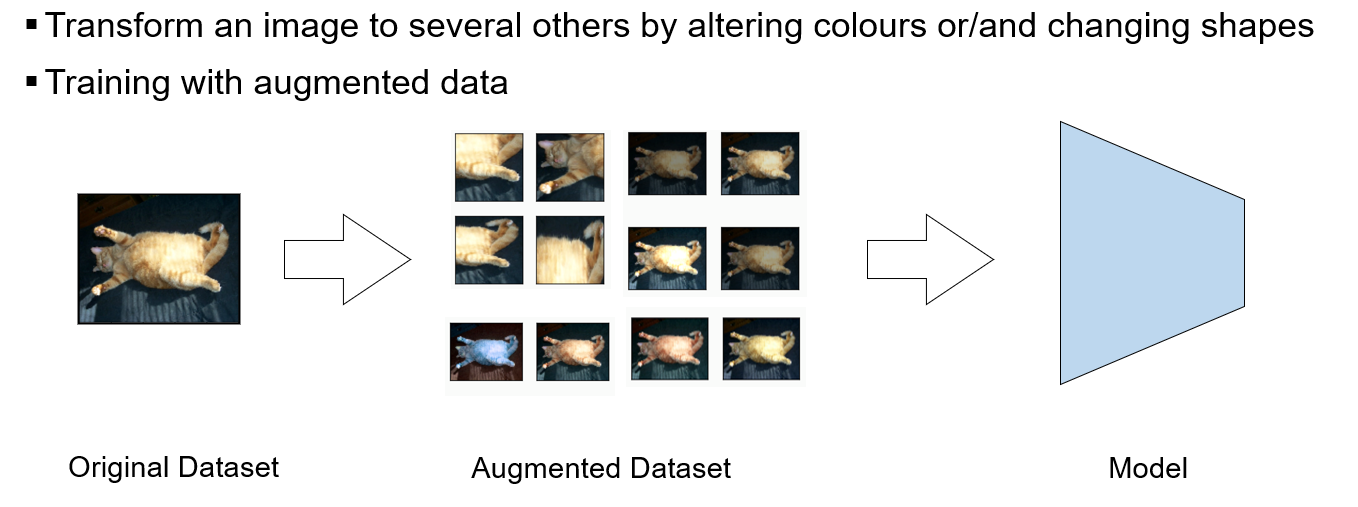

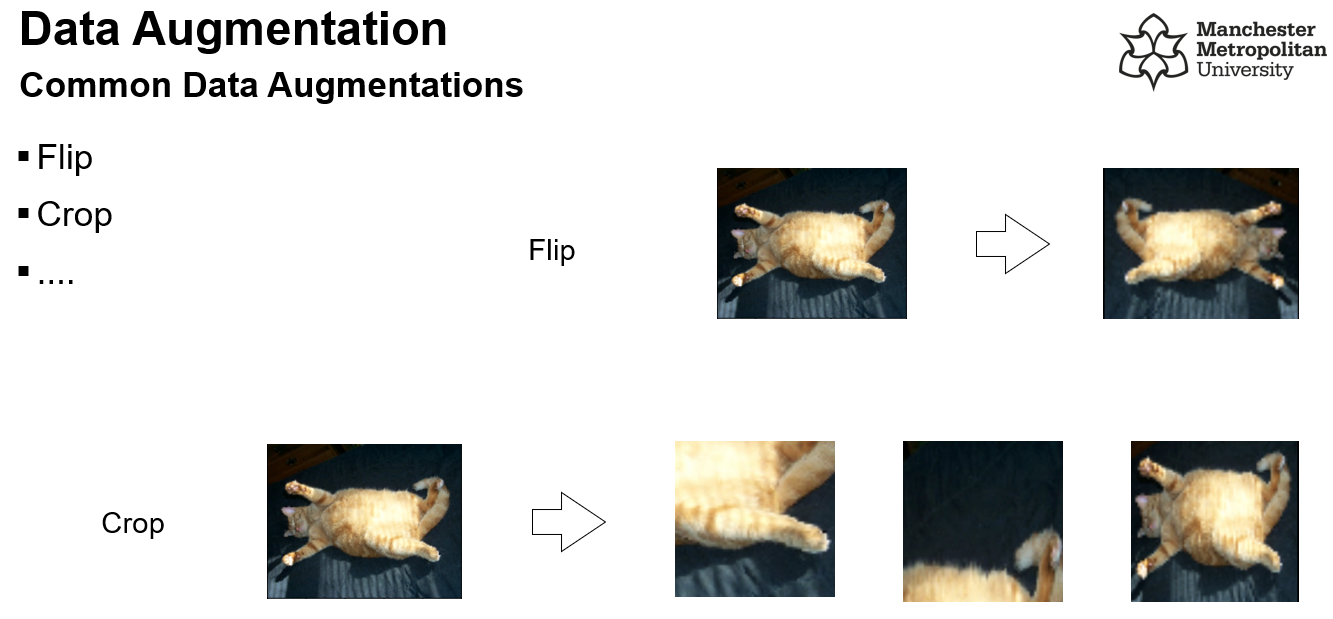

We can use the following part of the code to replace the orginal transformation to apply data augmentation to see if there is an improvement.

```
import torchvision.transforms as transforms

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),  # Random crop and resize
    transforms.RandomHorizontalFlip(),       # Random horizontal flip
    transforms.RandomRotation(degrees=10),    # Random rotation
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Adjust color
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])
```



## 7.2 Use Pretrained Model and Weights

For example, if we use ResNet-18 as our model:

`model = torchvision.models.resnet18(num_classes=7)`

There are more models in [torchvision.models](https://pytorch.org/vision/stable/models.html). We can access AlexNet, DenseNet, GooLeNet, InceptionNet, MobileNet, etc.

We can also load model parameters trained on ImageNet, but we have to manually modify the output number of classes.

`model = torchvision.models.resnet18(pretrained=True)  `
